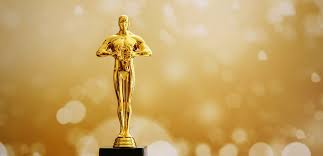

# Introduction to the Actors IMDb Web Scraper

This notebook focuses on web scraping actor data from IMDb using BeautifulSoup. The goal is to efficiently collect information for each actor, including: 

- The number of acting credits,
- The total number of award wins, 
- The total number of award nominations

Here's how we'll do this: 

- Load and inspect the scraped actor data from the movie details CSV. This CSV should have the first 3 actors listed for each movie in IMDb's Top 250 Chart and their URLs.
- Clean and preprocess the dataset to use as input for the scraping.
- Scrape the data using BeautifulSoup.
- Review the collected results. 

# Imports

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
import random
import re
import time
from IPython.display import FileLink

In [ ]:
# Import 
movie_data = pd.read_csv('datasets/movie_details_8FEB.csv')

# Preprocessing

Using the output from our Movie Details work, this section imports that CSV and processes it. The goal for this step is to create a list of actors and their URLS that we'll then use as an imput for scraping.

In [ ]:
# Examine the imported dataframe
movie_data.info()

In [ ]:
# Create a list of the columns
movie_data.columns.to_list()

## Tidying the Dataframe

The dataframe has a lot of information we don't need for scraping the actors. Using the column list above, we'll drop the unnecessary columns. 

In [ ]:
# Data we want to drop
columns_to_drop = ['rank',
 'year',
 'rating',
 'duration',
 'imdb_rating',
 'genre',
 'url',
 'movie_url',
 'popularity_score',
 'oscar_wins',
 'oscar_nominations']

# Dropping the extra columsn
movie_stars = movie_data.drop(columns=columns_to_drop, axis=1)

# Check our work
movie_stars

The resulting dataframe has 3 actors and their links on each row. The links also have some extra information. 


To tidy thigns further, here's what we'll do:
- Iterrate through each row of the dataframe, collecting the three actors and their respective links.
- Store each actor and their link in as a list `[name, actor_url]`, add each to a list
- Turn that list into a dataframe so we can tidy up the data: removing duplicates and later cleaning the links 

In [ ]:
# Create a list for the actor data
actor_data = []

# Loop through each row in the `movie_stars` dataframe
for index, row in movie_stars.iterrows():
    # Append each actor and their corresponding IMDb link
    actor_data.append([row["star_1"], row["star_1_link"]])
    actor_data.append([row["star_2"], row["star_2_link"]])
    actor_data.append([row["star_3"], row["star_3_link"]])

# Create a dataframe for easier cleaning
actors_df = pd.DataFrame(actor_data, columns=["name", "actor_url"])

# Remove duplicates
actors_df = actors_df.drop_duplicates()

# Check our work
actors_df


### Tidying the Actor URLs with Regular Expressions
The resulting dataframe has duplicates removed, but the links need addressing. The plan is to use regular expressions to tidy this up.

In [ ]:
# Look at the URL formatting... 
movie_stars['star_1_link'].head()

In [ ]:
# Shorten the URL to remove the extra
actors_df["actor_url"] = actors_df["actor_url"].str.replace(r"(\?.*)|(/$)", "", regex=True)

In [ ]:
# Check the results
actors_df

In [ ]:
# Check the length
len(actors_df)

## The Actors List
Our data is still in a dataframe, now we'll transform it into a list.

In [ ]:
# Turn the data into a list
actors_list = actors_df.values.tolist()

In [ ]:
# Check our work
len(actors_list)

We now have a list of actors with their urls in a list format for our scraper! Victory!

The results are 649 unique actors to scrape. 

# Fetching the Actor Data: Acting Credits, Award Wins, and Nominations

To get a better picture of the actors in our dataset, we’re pulling in some extra details about their careers. The functions below will help us gather key stats, including:

- Acting Credits – How many roles they've had
- Total Award Wins – The number of times they’ve taken home an award
- Total Award Nominations – How often they’ve been nominated for an award


This data will give us a clearer view of each actor’s experience, recognition, and overall impact in the industry. With this data, we’ll be able to explore interesting trends—like whether award-winning actors tend to star in more successful films!

## Web Scraping with BeautifulSoup


### Fetching Actor Metrics

How this is organized: 

1. Functions for gathering metrics: 
Each metric we’re collecting has its own function, allowing us to test and debug them separately.These functions use BeautifulSoup to scrape the necessary data:

- `get_actor_credits(actor_url)` – Retrieves the total number of acting credits for a given actor.
-`get_awards_data(actor_url)` – Fetches the total number of award wins and nominations.

You'll see a test block below each one, in case you need to debug before moving onto the whole scraping process.

2. Managing the scraping process:
Once the individual functions are in place, we use `scrape_actor_data(actor_url)` to task manage the scraping workflow.

- This function calls both `get_actor_credits` and `get_awards_data` for each actor
- It compiles the collected data into a dictionary
- A test block follows to verify its output.

By structuring the notebook this way, we ensure each part of the process can be tested independently before combining everything into a full dataset.

**Functions for gathering the acting credits and award wins:**

In [ ]:
# Define headers to mimic a real browser
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.6834.160 Safari/537.36"
}

In [ ]:
# Get the number of acting credits for an actor/actress using BeautifulSoup
def get_actor_credits(actor_url):
    #print("Fetching actor credits for:", actor_url)
    
    # Respect IMDb with a random delay
    time.sleep(random.uniform(4, 6))  

    response = requests.get(actor_url, headers=HEADERS) # Mimic a real browser
    
    # Let us know if we're not getting the page
    if response.status_code != 200:
        print("❌Failed to fetch page, status code:", response.status_code)
        return 0

    # If successful, parse the HTML
    soup = BeautifulSoup(response.text, "html.parser") 

    # Check for the Actor and Actress buttons
    button = soup.find("button", id="name-filmography-filter-actor") or \
             soup.find("button", id="name-filmography-filter-actress")
    
    # Extract the number of credits as text and turn it into an int
    if button:
        count_span = button.find("span", class_="ipc-chip__count")
        if count_span:
            match = re.search(r"\d+", count_span.text)
            if match:
                credits = int(match.group())
                #print("✅ Acting credits:", credits)
                return credits

    print("No acting credits found.")
    return 0

In [ ]:
# # Testing for actor credits
# url = "https://www.imdb.com/name/nm0000658/"  # Meryl Streep
# credits = get_actor_credits(url)
# print("Total Acting Credits:", credits)


In [ ]:
# Get the total number of wins & nominations using BeautifulSoup
def get_awards_data(actor_url):
    awards_url = actor_url + "awards"  # Append /awards to the actor's IMDb URL
    #print("Fetching awards from:", awards_url)

    time.sleep(random.uniform(4, 6))  # Prevent IMDb rate-limiting

    response = requests.get(awards_url, headers=HEADERS)
    if response.status_code != 200:
        print("Failed to fetch awards page, status code:", response.status_code)
        return 0, 0

    soup = BeautifulSoup(response.text, "html.parser")

    # Find the div containing the awards summary
    awards_div = soup.find("div", class_="ipc-signpost__text")
    if not awards_div:
        print("Awards information not found", actor_url)
        return 0, 0

    # Extract numbers as text using regex and turn them into integers
    match = re.search(r"(\d+)\s+wins?.*?(\d+)\s+nominations?", awards_div.text)
    if match:
        wins, nominations = int(match.group(1)), int(match.group(2))
        #print("Wins:", wins, "Nominations:", nominations)
        return wins, nominations

    print("No awards data found.")
    return 0, 0

In [ ]:
# # Testing the awards data function
# url = "https://www.imdb.com/name/nm0000138/"  # Leonardo DiCaprio
# wins, nominations = get_awards_data(url)
# print("Total Wins:", wins, "Total Nominations:", nominations)

Now that we can gather the data individually, we'll have our function get the data for each actor and return a dictionary.

In [ ]:
# Our task manager function to collect the actor's data
def scrape_actor_data(actor_name, actor_url):
    print("Scraping data for:", actor_name)
    
    # Get the actor credits
    actor_credits = get_actor_credits(actor_url)
    
    # Get the award wins
    wins, nominations = get_awards_data(actor_url)

    # Return the results in a dictionary
    return {
        "name": actor_name,
        "actor_credits": actor_credits,
        "total_wins": wins,
        "total_nominations": nominations
    }

In [ ]:
# # Test our task manager
# url = "https://www.imdb.com/name/nm0348409"  # Bob Gunton (144 credits, 2 wins, 1 nomination)
# actor_data = scrape_actor_data("Bob Gunton", url)
# print(actor_data)

### Scaling the Web Scraping

When originally doing this, it quickly became clear that scraping data at scale can take some time. 

To speed up data collection we have two functions:

**1. `scrape_all_actors(actor_list)`.**
- This uses `ThreadPoolExecutor` to fetch the actor details, with up to 10 parallel threads/ web workers. It returns a dataframe of our scraped actor data. 


Submitting the scraping tasks to be executed: 
- A dictionary `futures` is created to map each future task to its corresponding actor. 
- `*actor` unpacks the tuple with the actors name and url. For example, `("Leonardo DiCaprio", "https://www.imdb.com/...")`. That information comes from our list we created earlier. 
- The process submits each actor data request and processes the results as they complete. 
- Uses error handling to prevent one failure from stopping the process.



**2. Batching function.**
There were some issues in testing with IMDb blocking too many requests at once, so we batch the list of actors into smaller groups. 



**3. Output.** As each batch completes a CSV files is saved to the `datasets` directory. When they all complete a final CSV is saved to that directory. 


In [ ]:
# Scrape IMDb data for multiple actors concurrently
def scrape_all_actors(actor_list):
    # A list to store the scraped data for each actor
    results = []
    
    # Creating a thread to run multiple web scraping tasks in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        # Submits a scraping task for each actor with unpacked arguments (*actor)
        futures = {executor.submit(scrape_actor_data, *actor): actor for actor in actor_list}
        
        
        # Process the results as soon as they are finished (rather than waiting for all tasks to be completed)
        for future in concurrent.futures.as_completed(futures):
            # Prevents one failure from stopping the whole process 
            try:
                results.append(future.result())   
            except Exception as e:
                print("Error:", e)

    return pd.DataFrame(results)

In [ ]:
# Scrapes IMDb data in batches to our webworkers
def scrape_all_actors_in_batches(actor_list, batch_size=100):
    total_actors = len(actor_list)
    all_results = []

    for i in range(0, total_actors, batch_size):
        batch = actor_list[i:i + batch_size]
        print(f"Processing batch {i//batch_size + 1} ({len(batch)} actors)...")

        # Run parallel scraping for the current batch
        df_batch = scrape_all_actors(batch)

        # Save batch results incrementally
        batch_filename = f"datasets/actor_awards_batch_{i//batch_size + 1}.csv"
        df_batch.to_csv(batch_filename, index=False)
        print(f"Saved batch {i//batch_size + 1} to {batch_filename}")

        # Store batch results in memory
        all_results.append(df_batch)

        # Sleep between batches to avoid triggering IMDb's rate limit
        time.sleep(5)  

    # Combine all batches into a final DataFrame
    final_df = pd.concat(all_results, ignore_index=True)
    
    # Save final results
    final_df.to_csv("datasets/top_actors.csv", index=False)
    print("Final results saved to top_actors.csv")

    return final_df
    

In [ ]:
# Before running the scrape, make sure we have our entire list of actors
print(len(actors_list))

### Start the Actor Web Scraping

In [ ]:
# Start the scraping!
actor_results = scrape_all_actors_in_batches(actors_list)

# Reviewing the Results from Actor Web Scraping

The scraped actor data has been saved to datasets/final_actor_details.csv. The full process takes 10-15 minutes to complete.

During the review, we noticed:

- Duplicate entries were introduced during scraping.
- Some websites were unreachable, leading to missing data.


In [ ]:
# Print the first few rows of results
actor_results.head(50)

In [ ]:
len(actor_results)

In [ ]:
actor_results.isna().sum()

In [ ]:
actor_results.duplicated().sum()

# Next Steps

This project work could continue to be improved. These are some ideas for next steps for the Actor Web Scraper:
- Handle Failed Requests: For actors whose pages couldn’t be reached, we might consider re-running the scraper for just those cases or implementing a retry mechanism in the future.

- Optimize Scraping Efficiency – If IMDb rate limits caused issues, adjusting request delays or reducing concurrency might improve success rates. 10-15 minutes seems reasonable, but maybe it could be faster. 

- Explore Additional Data. If relevant, we could enhance the dataset by including more details, such as career progression over time.

This work continues on in the Data Analysis notebook. 